In [1]:
import gzip
import json
import statistics
import matplotlib.pyplot as plt
import numpy as np
from typing import Iterator

import pandas as pd
from plotnine import *
from surprise import (
    accuracy,
    AlgoBase,
    BaselineOnly,
    Dataset,
    KNNBasic,
    KNNWithZScore,
    NormalPredictor,
    Reader,
    SlopeOne,
    SVD,
    KNNBaseline,
)
from surprise.model_selection import cross_validate, train_test_split


pd.set_option("max_colwidth", None)

# Table of Contents

- [Step B.1](#Step-B.1)
- [Step B.2](#Step-B.2)
- [Step B.3](#Step-B.3)
- [Step B.4](#Step-B.4)

In [2]:
# disclaimer: may not work as is in Windows OS
# download the “small” 5-core dataset for the category "Digital Music"
# dataset source: https://nijianmo.github.io/amazon/index.html

!wget --backups=1 http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz -P data/

--2022-03-20 13:32:59--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19408584 (19M) [application/octet-stream]
Saving to: ‘data/Digital_Music_5.json.gz’

Digital_Music_5.jso 100%[===================>]  18.51M  1.85MB/s    in 25s     

2022-03-20 13:33:24 (757 KB/s) - ‘data/Digital_Music_5.json.gz’ saved [19408584/19408584]



## Step B.1

In [3]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [4]:
def parse(filepath: str) -> Iterator[dict]:
    file_obj = gzip.open(filepath, "rb")
    for line in file_obj:
        yield json.loads(line)

In [5]:
def file_to_dataframe(filepath: str) -> pd.DataFrame:
    i = 0
    df = {}
    for d in parse(filepath):
        df[i] = {
            "user": d["reviewerID"],
            "item": d["asin"],
            "rating": d["overall"],
        }  # keep only the essential data
        i += 1
    return pd.DataFrame.from_dict(df, orient="index")

In [6]:
review_data = file_to_dataframe("data/Digital_Music_5.json.gz")

In [7]:
reader = Reader(rating_scale=(1, 5))

In [8]:
data = Dataset.load_from_df(review_data[["user", "item", "rating"]], reader)

inspect_df(data.df, 10)

shape: (169781, 3)


,user,item,rating
0,A2TYZ821XXK2YZ,3426958910,5.0
1,A3OFSREZADFUDY,3426958910,5.0
2,A2VAMODP8M77NG,3426958910,5.0
3,AAKSLZ9IDTEH0,3426958910,4.0
4,A3OH43OZJLKI09,5557706259,5.0
5,A6JP9YYJCK3WO,5557706259,4.0
6,A20Z0JD766DPG6,5557706259,5.0
7,AXQ89O6YRT7AX,5557706259,5.0
8,A1M379MK8MKGUF,5557706259,5.0
9,AA762OWLWCPQ2,5557706259,5.0


## Step B.2

In [9]:
cv_results = {}
x = [1, 2, 3, 4, 5]

In [10]:
"""
Algorithm predicting a random rating based on the distribution of the training set, 
which is assumed to be normal.
"""
cv_results["NormalPredictor"] = cross_validate(
    algo=NormalPredictor(), data=data, verbose=True, cv=5
)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8942  0.8918  0.8925  0.8923  0.8816  0.8905  0.0045  
MAE (testset)     0.5904  0.5900  0.5921  0.5919  0.5853  0.5899  0.0025  
Fit time          0.11    0.15    0.14    0.14    0.14    0.13    0.01    
Test time         0.22    0.14    0.15    0.13    0.13    0.15    0.04    


In [11]:
"""
Algorithm predicting the baseline estimate for given user and item.
"""
cv_results["BaselineOnly"] = cross_validate(
    algo=BaselineOnly(), data=data, verbose=True, cv=5
)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5891  0.5819  0.5842  0.6016  0.6021  0.5918  0.0085  
MAE (testset)     0.3707  0.3673  0.3676  0.3722  0.3743  0.3704  0.0027  
Fit time          0.40    0.42    0.47    0.42    0.44    0.43    0.02    
Test time         0.08    0.08    0.17    0.18    0.16    0.13    0.04    


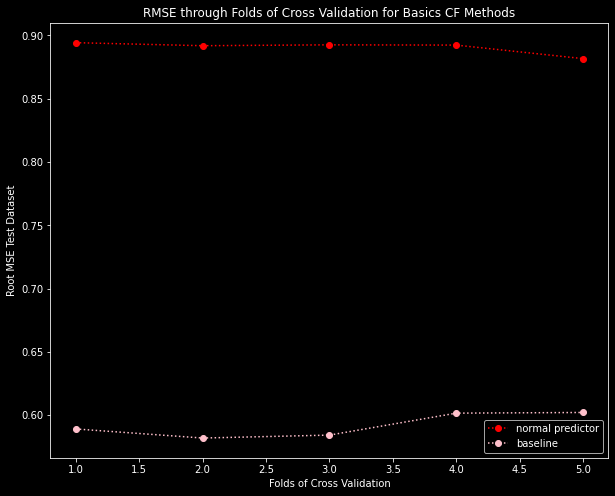

In [12]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]

plt.plot(
    x,
    cv_results["NormalPredictor"]["test_rmse"],
    color="red",
    marker="o",
    linestyle="dotted",
    label="normal predictor",
)
plt.plot(
    x,
    cv_results["BaselineOnly"]["test_rmse"],
    color="pink",
    marker="o",
    linestyle="dotted",
    label="baseline",
)

plt.title("RMSE through Folds of Cross Validation for Basics CF Methods")
plt.xlabel("Folds of Cross Validation")
plt.ylabel("Root MSE Test Dataset")
plt.legend()
plt.show()

In [13]:
"""
A basic item-item collaborative filtering algorithm.
"""
cv_results["KNNBasic (cosine) item-based"] = cross_validate(
    algo=KNNBasic(
        sim_options={
            "name": "cosine",
            "user_based": False,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6115  0.6070  0.6183  0.6049  0.6101  0.6104  0.0046  
MAE (testset)     0.3146  0.3135  0.3187  0.3094  0.3148  0.3142  0.0030  
Fit time          4.48    4.45    4.54    4.55    4.42    4.49    0.05    
Test time         0.67    0.65    0.66    0.58    0.60    0.63    0.04    


In [14]:
"""
A basic collaborative filtering algorithm taking into account a baseline rating.
It computes the (shrunk) Pearson correlation coefficient between all pairs of items 
using baselines for centering instead of means.
"""
cv_results["KNNPearson with baseline"] = cross_validate(
    algo=KNNBaseline(sim_options={"name": "pearson_baseline", "user_based": False}),
    data=data,
    verbose=True,
    cv=5,
)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5391  0.5349  0.5362  0.5396  0.5405  0.5380  0.0021  
MAE (testset)     0.2692  0.2684  0.2698  0.2749  0.2723  0.2709  0.0024  
Fit time          4.39    4.49    4.38    4.20    4.50    4.39    0.11    
Test time         0.59    0.70    0.70    0.66    0.5

In [15]:
"""
A simple yet accurate item-based collaborative filtering algorithm.

This is a straightforward implementation of the SlopeOne algorithm: https://arxiv.org/abs/cs/0702144
"""
cv_results["SlopeOne"] = cross_validate(
    algo=SlopeOne(),
    data=data,
    verbose=True,
    cv=5,
)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5866  0.5705  0.5721  0.5832  0.5907  0.5806  0.0080  
MAE (testset)     0.2727  0.2673  0.2685  0.2729  0.2776  0.2718  0.0037  
Fit time          2.42    2.59    2.60    2.60    2.46    2.53    0.08    
Test time         0.40    0.40    0.42    0.46    0.45    0.43    0.03    


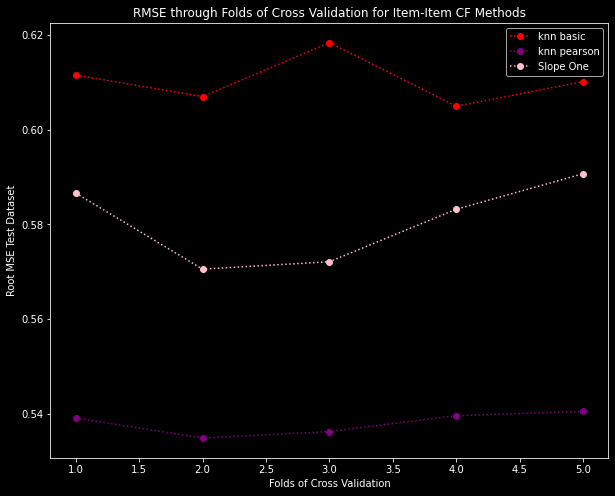

In [16]:
plt.plot(
    x,
    cv_results["KNNBasic (cosine) item-based"]["test_rmse"],
    color="red",
    marker="o",
    linestyle="dotted",
    label="knn basic",
)
plt.plot(
    x,
    cv_results["KNNPearson with baseline"]["test_rmse"],
    color="purple",
    marker="o",
    linestyle="dotted",
    label="knn pearson",
)
plt.plot(
    x,
    cv_results["SlopeOne"]["test_rmse"],
    color="pink",
    marker="o",
    linestyle="dotted",
    label="Slope One",
)

plt.title("RMSE through Folds of Cross Validation for Item-Item CF Methods")
plt.xlabel("Folds of Cross Validation")
plt.ylabel("Root MSE Test Dataset")
plt.legend()
plt.show()

In [17]:
"""
A basic user-user collaborative filtering algorithm.
"""
cv_results["KNNBasic (cosine) user-based"] = cross_validate(
    algo=KNNBasic(
        sim_options={
            "name": "cosine",
            "user_based": True,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7670  0.7782  0.7718  0.7699  0.7690  0.7712  0.0039  
MAE (testset)     0.4644  0.4703  0.4653  0.4648  0.4636  0.4657  0.0024  
Fit time          8.98    9.03    8.57    8.80    8.66    8.81    0.18    
Test time         0.81    0.82    1.00    0.89    1.24    0.95    0.16    


In [18]:
"""
A basic collaborative filtering algorithm, taking into account
the z-score normalization of each user.
"""
cv_results["KNNWithZScore (MSD) user-based"] = cross_validate(
    algo=KNNWithZScore(
        sim_options={
            "name": "msd",
            "user_based": True,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5808  0.5971  0.5774  0.5903  0.5790  0.5849  0.0076  
MAE (testset)     0.2885  0.2951  0.2880  0.2943  0.2868  0.2905  0.0035  
Fit time          5.66    5.49    5.88    5.92    5.95    5.78    0.18    
Test time         0.96    0.90    0.89    0.90    0.99    0.93    0.04    


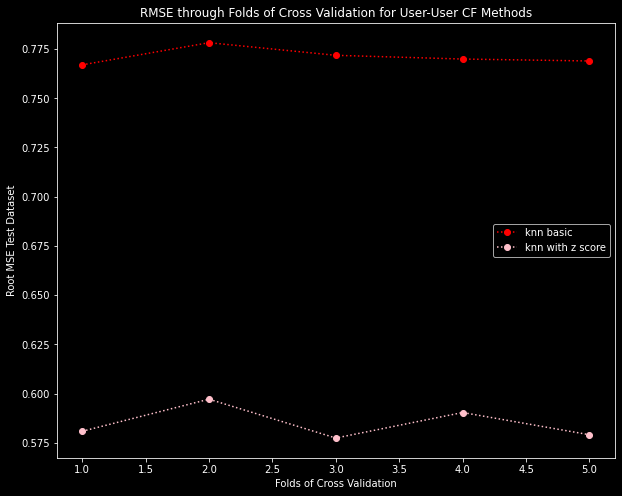

In [19]:
plt.plot(
    x,
    cv_results["KNNBasic (cosine) user-based"]["test_rmse"],
    color="red",
    marker="o",
    linestyle="dotted",
    label="knn basic",
)
plt.plot(
    x,
    cv_results["KNNWithZScore (MSD) user-based"]["test_rmse"],
    color="pink",
    marker="o",
    linestyle="dotted",
    label="knn with z score",
)

plt.title("RMSE through Folds of Cross Validation for User-User CF Methods")
plt.xlabel("Folds of Cross Validation")
plt.ylabel("Root MSE Test Dataset")
plt.legend()
plt.show()

In [20]:
"""
The famous SVD algorithm, as popularized by `Simon Funk
<http://sifter.org/~simon/journal/20061211.html>`_ during the Netflix Prize.
"""
cv_results["SVD"] = cross_validate(algo=SVD(), data=data, verbose=True, cv=5)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5771  0.5551  0.5626  0.5624  0.5526  0.5619  0.0085  
MAE (testset)     0.3379  0.3312  0.3377  0.3355  0.3325  0.3350  0.0027  
Fit time          5.54    5.61    5.57    5.49    5.47    5.54    0.05    
Test time         0.15    0.15    0.14    0.23    0.22    0.18    0.04    


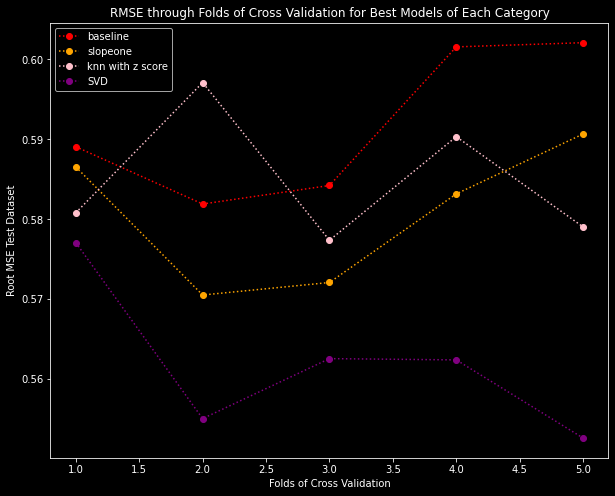

In [21]:
plt.style.use("dark_background")
plt.plot(
    x,
    cv_results["BaselineOnly"]["test_rmse"],
    color="red",
    marker="o",
    linestyle="dotted",
    label="baseline",
)
plt.plot(
    x,
    cv_results["SlopeOne"]["test_rmse"],
    color="orange",
    marker="o",
    linestyle="dotted",
    label="slopeone",
)
plt.plot(
    x,
    cv_results["KNNWithZScore (MSD) user-based"]["test_rmse"],
    color="pink",
    marker="o",
    linestyle="dotted",
    label="knn with z score",
)
plt.plot(
    x,
    cv_results["SVD"]["test_rmse"],
    color="purple",
    marker="o",
    linestyle="dotted",
    label="SVD",
)


plt.title("RMSE through Folds of Cross Validation for Best Models of Each Category")
plt.xlabel("Folds of Cross Validation")
plt.ylabel("Root MSE Test Dataset")
plt.legend()
plt.show()

## Step B.3

In [22]:
df = pd.DataFrame(cv_results).T.reset_index()

df["mean RMSE"] = df["test_rmse"].map(lambda x: statistics.mean(x))

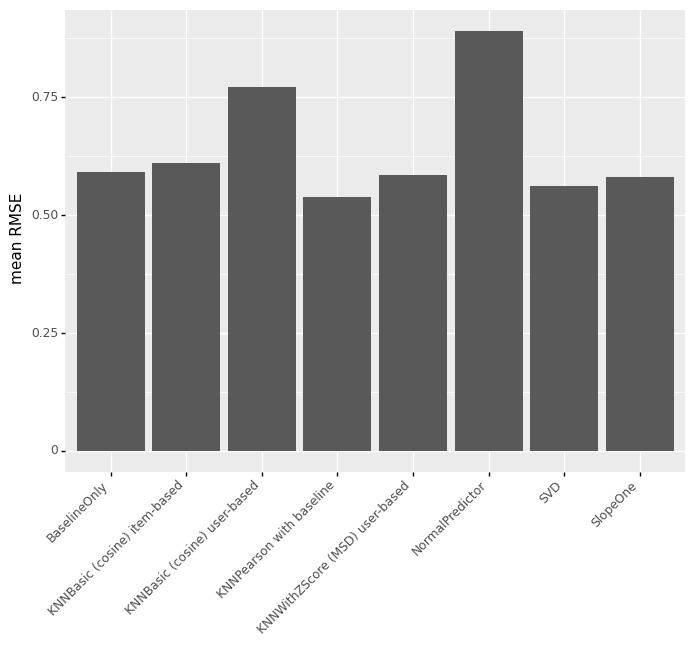

<ggplot: (8755091248406)>

In [23]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE")
)

## Step B.4

In [24]:
trainset, testset = train_test_split(data, test_size=0.25)

In [25]:
best_algo = KNNBaseline(sim_options={"name": "pearson_baseline", "user_based": False})

In [26]:
recsys = best_algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [27]:
def get_recommendations_for_user(user: str, rs: AlgoBase, n: int = 5) -> list:

    # get n random unseen products for this user
    unseen_items = review_data[review_data["user"] != user]["item"].unique()

    predictions = [*map(lambda item: rs.predict(uid=user, iid=item), unseen_items)]

    return sorted(predictions, key=lambda p: p.est, reverse=True)[:n]

In [28]:
users = list(set((u for u, _, _ in testset)))

for user in users[:5]:  # show recommendations for first 5 users, no need to display all
    for recommendation in get_recommendations_for_user(user, rs=recsys, n=5):
        print(recommendation)
    print("=" * 105)

user: A14L52QX51WILZ item: B00I83XD14 r_ui = None   est = 4.94   {'actual_k': 0, 'was_impossible': False}
user: A14L52QX51WILZ item: B001EE4PUM r_ui = None   est = 4.80   {'actual_k': 0, 'was_impossible': False}
user: A14L52QX51WILZ item: B00DJMS152 r_ui = None   est = 4.74   {'actual_k': 0, 'was_impossible': False}
user: A14L52QX51WILZ item: B000VWU2NC r_ui = None   est = 4.67   {'actual_k': 0, 'was_impossible': False}
user: A14L52QX51WILZ item: B00138CX5S r_ui = None   est = 4.66   {'actual_k': 0, 'was_impossible': False}
user: A2Y1M1OFYKRZ3J item: B000VRQQRS r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}
user: A2Y1M1OFYKRZ3J item: B000VRPFJI r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}
user: A2Y1M1OFYKRZ3J item: B000VWU2NC r_ui = None   est = 5.00   {'actual_k': 0, 'was_impossible': False}
user: A2Y1M1OFYKRZ3J item: B000W25BXM r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}
user: A2Y1M1OFYKRZ3J item: B0012250PA r_ui = N

In [29]:
users = pd.DataFrame(dict(user=review_data["user"].unique()))

users["top_recommendations"] = users["user"].map(
    lambda x: get_recommendations_for_user(x, recsys, n=5)
)

In [30]:
users["top_recommendations"] = users["top_recommendations"].map(
    lambda recommendations: [p.iid for p in recommendations]
)

In [31]:
users

,user,top_recommendations
0,A2TYZ821XXK2YZ,"[3426958910, 9714721180, B000S55TTY, B000T31G8S, 9721717150]"
1,A3OFSREZADFUDY,"[B000S55TTY, B000VWU2NC, B000W1T29M, B000WLOMUQ, B000WOXVOQ]"
2,A2VAMODP8M77NG,"[3426958910, 9714721180, B000S55TTY, B000T31G8S, B000VRQQRS]"
3,AAKSLZ9IDTEH0,"[B00I83XD14, B001EE4PUM, B00DJMS152, B000VWU2NC, B00138CX5S]"
4,A3OH43OZJLKI09,"[5557706259, B000WT62UQ, B00138JD1U, B0013D8BK4, B001E5422C]"
...,...,...
16561,A2XABEL5QL0BKC,"[B0011W1W5S, B00137MTF8, B009EAO8GE, B00CC1KIGQ, B00G2IAIVK]"
16562,A23OQL552RQ7UN,"[B001EE4PUM, B00I83XD14, B00ONGFA66, B00DJMS152, B000VWU2NC]"
16563,A17FFQTRJ4JHZ7,"[B000S55TTY, B000VWU2NC, B00122X3D6, B00136NQ6U, B00136PTYW]"
16564,A3IIO38JUX49QS,"[B000VWU2NC, B00137QS2I, B00138CX5S, B001EE4PUM, B00DJMS152]"


In [32]:
del users

In [33]:
item_unique = data.df["item"].unique()

In [ ]:
rankings_per_user = pd.DataFrame(dict(user=review_data["user"].unique()))
rankings_per_user["top_recommendations"] = rankings_per_user["user"].map(
    lambda x: get_recommendations_for_user(x, recsys, n=len(item_unique))
)

In [ ]:
rankings_per_user["top_recommendations"] = rankings_per_user["top_recommendations"].map(
    lambda recommendations: [p.iid for p in recommendations]
)

In [ ]:
rankings_per_user

In [ ]:
rankings_per_user.to_pickle("data/collab-filtering-RS.pkl")